# Cumulative event counter

### This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of apoptosis events

1. Load dictionary of ~apoptoses~ events and their corresponding times to base the spatiotemporal scans around 
2. Load corresponding tracking data and specify scan parameters
3. Iteratively calculate spatiotemporal distribution of cellular events around apoptoses, saving each distribution out as a .npy distance-time heatmap
4. Compile list of spatiotemporal heatmaps as cumulative heatmap
5. Misc. section: comparing different experimental conditions

In [2]:
import calculate_radial_analysis as calculate
import tools
import render
import dataio

import json
import glob
import os
import re
import numpy as np
from natsort import natsorted
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

## 1) Event dictionary loader

Specify cell type to filter out unwanted apoptoses, want end result of event_dict that takes the format of :`event_dict = {event_ID:event_time}` 

where `event_ID` takes the format of: `GV{experiment_ID}_Pos{position_ID}_{cell_ID}_{cell_type}` 

For example: 

```
event_dict = {'GV0794_Pos4_393_GFP': '766',
             'GV0794_Pos7_364_GFP': '550',
             'GV0794_Pos7_457_GFP': '805',
             'GV0794_Pos7_369_GFP': '833',
             'GV0794_Pos7_292_GFP': '884',
             'GV0795_Pos4_358_GFP': '628',
             'GV0795_Pos4_18_GFP': '855',
             'GV0795_Pos4_1356_GFP': '992',
             'GV0795_Pos4_359_GFP': '1133',
             'GV0796_Pos4_542_GFP': '581',
             'GV0796_Pos4_1334_GFP': '719',
             'GV0796_Pos4_1586_GFP': '785'}
 ```
 
Function to apoptosis event dictionary from preexisting data store:

`dataio.apoptosis_list_loader(path_to_apop_lists, cell_type)`

Where the `path_to_apop_lists` is the directory containing the apoptosis information and the `cell_type` is either `'Scr'` or `'WT'`.

In [3]:
path_to_apop_lists = '/media/nathan/Transcend/Nathan/data/kraken/h2b/apoptosis_information/final/all'
event_dict = dataio.apoptosis_list_loader(path_to_apop_lists, 'Scr')
event_dict

{'GV0804_Pos4_179_RFP': '625',
 'GV0804_Pos4_249_RFP': '850',
 'GV0804_Pos4_110_RFP': '851',
 'GV0804_Pos4_292_RFP': '902',
 'GV0804_Pos4_342_RFP': '999',
 'GV0804_Pos4_343_RFP': '1002',
 'GV0804_Pos4_231_RFP': '1010',
 'GV0804_Pos4_339_RFP': '1009',
 'GV0804_Pos4_333_RFP': '1014',
 'GV0804_Pos4_353_RFP': '1050',
 'GV0804_Pos4_351_RFP': '1084',
 'GV0804_Pos4_163_RFP': '1074',
 'GV0804_Pos4_217_RFP': '1142',
 'GV0794_Pos4_6_RFP': '469',
 'GV0794_Pos4_73_RFP': '773',
 'GV0794_Pos4_70_RFP': '820',
 'GV0794_Pos7_52_RFP': '195',
 'GV0794_Pos7_192_RFP': '258',
 'GV0794_Pos7_352_RFP': '749',
 'GV0794_Pos7_328_RFP': '827',
 'GV0794_Pos7_329_RFP': '846',
 'GV0794_Pos7_360_RFP': '874',
 'GV0794_Pos7_429_RFP': '889',
 'GV0795_Pos4_1_RFP': '6',
 'GV0795_Pos4_7_RFP': '8',
 'GV0795_Pos4_103_RFP': '472',
 'GV0795_Pos4_284_RFP': '639',
 'GV0795_Pos4_235_RFP': '642',
 'GV0795_Pos4_234_RFP': '671',
 'GV0795_Pos4_285_RFP': '654',
 'GV0795_Pos4_223_RFP': '418',
 'GV0795_Pos4_323_RFP': '956',
 'GV0795_Pos4

### Update: 

Currently implementing focal scan around divisions (originally was just apoptoses)

In [3]:
with open('/home/nathan/data/kraken/h2b/giulia/experiment_information/divisions/scr_div_dict_confident.json', 'r') as file:
    event_dict = json.load(file)
event_dict

FileNotFoundError: [Errno 2] No such file or directory: '/home/nathan/data/kraken/h2b/giulia/experiment_information/divisions/scr_div_dict_confident.json'

In [ ]:
### optional parallelisation step
N_focal = len(event_dict)
para_frac_min, para_frac_max = int(0*N_focal), int(1*N_focal)  ## ie only do first 1/4 of all apops
delete_list =[]
for i, j in enumerate(event_dict):
    if not para_frac_min <= i< para_frac_max: 
        delete_list.append(j)
for i in delete_list:
    del event_dict[i]
print("Length of modified dict vs original:", len(event_dict), "/", N_focal)

## 2) Load corresponding cell tracking data and specifiy other parameters

`dataio.hdf5_file_finder(parent_folder_hdf5)` loads a list of all hdf5 files when supplied with the parent directory of all the experiments. This relies on a typical sub-parent directory structure of `'GV****/Pos*/*aligned/HDF/segmented.hdf5'` (aligned folder optional)

In [22]:
### load tracking data
parent_folder_hdf5 = '/media/nathan/Transcend/Nathan/data/kraken/h2b'
hdf5_file_list = dataio.hdf5_file_finder(parent_folder_hdf5)

### specify output path and neighbourhood scan parameters
radius, t_range, num_bins = 400, 400, 20
output_path = '/media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/{}.{}.{}/scr_apop_scr_apop'.format(radius, t_range, num_bins)
Path(output_path).mkdir(parents=True, exist_ok=True)

## 3) Iteratively calculate and save out individual heatmaps

This step can be time consuming (sequential scans around 385 apoptoses took 7 hours on i7)

Function to calculate:

`calculate.iterative_heatmap_generator(subject_cells = 'WT', subject_event = 'DIVIDE', apop_dict, hdf5_file_list, radius, t_range, num_bins, output_path)`

Where the necessary input variables are as follows:
- `subject_cells` = The population of cells to scan over looking for events, 'WT'/'Scr'/'All'
- `subject_event` = The event type to look for, 'DIVIDE' or 'APOPTOSIS'
- `apop_dict` = Previously defined python dictionary of {apoptosis ID: apoptosis time}
- `hdf5_file_list` = List of locations of tracking files
- `radius` = Distance to scan over around apoptosis
- `t_range` = Time range to scan over around apoptosis (will scan t_range/2 before and after apoptosis)
- `num_bins` = Number of bins the histogram is sorted into
- `output_path` = Empty directory to save out individual apoptosis heatmap .npy arrays into


In [ ]:
N_cells, error_log, success_log = calculate.iterative_heatmap_generator(
    'Scr',
    'APOPTOSIS', 
    event_dict, 
    hdf5_file_list, 
    radius, 
    t_range, 
    num_bins, 
    output_path)

If you want to save out raw list of cell IDs, distance and frames, enter 'y', else just press entery


  0%|          | 0/1839 [00:00<?, ?it/s]

[INFO][2022/02/22 02:07:18 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:07:18 PM] Loading tracks/obj_type_1


ID GV0804_Pos4_179_RFP
Loading GV0804/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:07:20 PM] Loading objects/obj_type_1 (271439, 5) (257929 filtered: area>=100)
[INFO][2022/02/22 02:07:23 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:07:23 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:07:23 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:07:23 PM] Loading objects/obj_type_2 (42112, 5) (36481 filtered: area>=100)
[INFO][2022/02/22 02:07:24 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0804/Pos4/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0804_Pos4_249_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0804_Pos4_110_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0804_Pos4_292_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0804_Pos4_342_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0804_Pos4_343_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0804_Pos4_231_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0804_Pos4_339_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0804_Pos4_333_RFP
Current apoptosis t

[INFO][2022/02/22 02:08:28 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:08:28 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos4_6_RFP
Loading GV0794/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:08:28 PM] Loading objects/obj_type_1 (69360, 5) (64986 filtered: area>=100)
[INFO][2022/02/22 02:08:29 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:08:29 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:08:29 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:08:29 PM] Loading objects/obj_type_2 (13865, 5) (10538 filtered: area>=100)
[INFO][2022/02/22 02:08:30 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos4/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos4_73_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos4_70_RFP


[INFO][2022/02/22 02:08:34 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:08:34 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos7_52_RFP
Loading GV0794/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:08:35 PM] Loading objects/obj_type_1 (110774, 5) (102450 filtered: area>=100)
[INFO][2022/02/22 02:08:36 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:08:36 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:08:36 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:08:36 PM] Loading objects/obj_type_2 (20793, 5) (17016 filtered: area>=100)
[INFO][2022/02/22 02:08:36 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos7/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos7_192_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos7_352_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos7_328_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos7_329_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos7_360_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0794_Pos7_429_RFP


[INFO][2022/02/22 02:09:00 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:09:00 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos4_1_RFP
Loading GV0795/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:09:02 PM] Loading objects/obj_type_1 (211479, 5) (197642 filtered: area>=100)
[INFO][2022/02/22 02:09:04 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:09:04 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:09:04 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:09:05 PM] Loading objects/obj_type_2 (49070, 5) (38203 filtered: area>=100)
[INFO][2022/02/22 02:09:05 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos4/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos4_7_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos4_103_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos4_284_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos4_235_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos4_234_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos4_285_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos4_223_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos4_323_RFP
Current apoptosis tim

[INFO][2022/02/22 02:12:07 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:12:07 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos7_37_RFP
Loading GV0795/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:12:08 PM] Loading objects/obj_type_1 (199943, 5) (183929 filtered: area>=100)
[INFO][2022/02/22 02:12:11 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:12:11 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:12:11 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:12:11 PM] Loading objects/obj_type_2 (80612, 5) (63990 filtered: area>=100)
[INFO][2022/02/22 02:12:12 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos7/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos7_390_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos7_421_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos7_460_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos7_263_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos7_264_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos7_680_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos7_874_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos7_873_RFP
Current apoptosis t

[INFO][2022/02/22 02:16:04 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:16:04 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos4_13_RFP
Loading GV0796/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:16:07 PM] Loading objects/obj_type_1 (441082, 5) (424178 filtered: area>=100)
[INFO][2022/02/22 02:16:12 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:16:12 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:16:12 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:16:13 PM] Loading objects/obj_type_2 (72743, 5) (60501 filtered: area>=100)
[INFO][2022/02/22 02:16:14 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos4/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos4_33_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos4_372_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos4_377_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos4_27_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos4_214_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos4_469_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos4_468_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos4_399_RFP
Current apoptosis tim

[INFO][2022/02/22 02:22:46 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:22:46 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos7_39_RFP
Loading GV0796/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:22:50 PM] Loading objects/obj_type_1 (510473, 5) (495699 filtered: area>=100)
[INFO][2022/02/22 02:22:57 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:22:57 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:22:57 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:22:58 PM] Loading objects/obj_type_2 (76238, 5) (63068 filtered: area>=100)
[INFO][2022/02/22 02:22:58 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos7/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos7_40_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos7_48_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos7_72_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos7_6_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos7_5_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos7_85_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos7_443_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos7_41_RFP
Current apoptosis timepoints

[INFO][2022/02/22 02:28:05 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:28:05 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos4_12_RFP
Loading GV0797/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:28:07 PM] Loading objects/obj_type_1 (298548, 5) (283305 filtered: area>=100)
[INFO][2022/02/22 02:28:12 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:28:12 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:28:12 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:28:12 PM] Loading objects/obj_type_2 (52032, 5) (37211 filtered: area>=100)
[INFO][2022/02/22 02:28:13 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos4/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos4_18_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos4_7_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos4_24_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos4_240_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos4_23_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos4_96_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos4_95_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos4_223_RFP
Current apoptosis timepoin

[INFO][2022/02/22 02:32:57 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:32:57 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos7_14_RFP
Loading GV0797/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:32:58 PM] Loading objects/obj_type_1 (207794, 5) (196573 filtered: area>=100)
[INFO][2022/02/22 02:33:01 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:33:01 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:33:01 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:33:01 PM] Loading objects/obj_type_2 (22939, 5) (18826 filtered: area>=100)
[INFO][2022/02/22 02:33:02 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos7/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos7_45_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos7_5_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos7_146_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos7_145_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos7_30_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos7_106_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos7_9_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos7_204_RFP
Current apoptosis timepoi

[INFO][2022/02/22 02:33:41 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:33:41 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos4_27_RFP
Loading GV0798/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:33:43 PM] Loading objects/obj_type_1 (233782, 5) (224796 filtered: area>=100)
[INFO][2022/02/22 02:33:45 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:33:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:33:45 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:33:45 PM] Loading objects/obj_type_2 (33185, 5) (26688 filtered: area>=100)
[INFO][2022/02/22 02:33:46 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos4/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos4_22_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos4_344_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos4_253_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos4_302_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos4_255_RFP


[INFO][2022/02/22 02:34:11 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:34:11 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos7_91_RFP
Loading GV0798/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:34:12 PM] Loading objects/obj_type_1 (264968, 5) (250270 filtered: area>=100)
[INFO][2022/02/22 02:34:16 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:34:16 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:34:16 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:34:16 PM] Loading objects/obj_type_2 (34780, 5) (28039 filtered: area>=100)
[INFO][2022/02/22 02:34:16 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos7/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos7_92_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos7_77_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos7_22_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos7_24_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos7_148_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos7_149_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos7_38_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos7_224_RFP
Current apoptosis timepo

[INFO][2022/02/22 02:35:39 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:35:39 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos4_7_RFP
Loading GV0800/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:35:41 PM] Loading objects/obj_type_1 (293631, 5) (274724 filtered: area>=100)
[INFO][2022/02/22 02:35:45 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:35:45 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:35:45 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:35:46 PM] Loading objects/obj_type_2 (60789, 5) (49434 filtered: area>=100)
[INFO][2022/02/22 02:35:46 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos4/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos4_33_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos4_24_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos4_482_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos4_374_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos4_351_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos4_352_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos4_471_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos4_274_RFP
Current apoptosis tim

[INFO][2022/02/22 02:38:28 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:38:28 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos7_7_RFP
Loading GV0800/Pos7/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:38:30 PM] Loading objects/obj_type_1 (299894, 5) (277008 filtered: area>=100)
[INFO][2022/02/22 02:38:34 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:38:34 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:38:34 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:38:34 PM] Loading objects/obj_type_2 (53124, 5) (43280 filtered: area>=100)
[INFO][2022/02/22 02:38:35 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos7/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos7_27_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos7_52_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos7_165_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos7_29_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos7_368_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos7_393_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos7_392_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0800_Pos7_456_RFP
Current apoptosis time

[INFO][2022/02/22 02:41:19 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:41:19 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos17_13_RFP
Loading GV0795/Pos17/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:41:20 PM] Loading objects/obj_type_1 (142287, 5) (125195 filtered: area>=100)
[INFO][2022/02/22 02:41:21 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos17/Pos17_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:41:21 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:41:21 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:41:22 PM] Loading objects/obj_type_2 (36319, 5) (29965 filtered: area>=100)
[INFO][2022/02/22 02:41:22 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0795/Pos17/Pos17_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos17/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos17_16_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos17_26_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos17_6_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos17_4_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos17_115_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos17_152_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos17_151_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0795_Pos17_129_RFP
Current apoptosi

[INFO][2022/02/22 02:43:17 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:43:17 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos21_13_RFP
Loading GV0796/Pos21/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:43:20 PM] Loading objects/obj_type_1 (307793, 5) (293005 filtered: area>=100)
[INFO][2022/02/22 02:43:24 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:43:24 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:43:24 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:43:24 PM] Loading objects/obj_type_2 (46439, 5) (38835 filtered: area>=100)
[INFO][2022/02/22 02:43:25 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos21/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos21_16_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos21_30_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos21_23_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos21_14_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos21_230_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos21_314_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos21_252_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos21_282_RFP
Current apopto

[INFO][2022/02/22 02:48:59 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:48:59 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos22_28_RFP
Loading GV0796/Pos22/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:49:01 PM] Loading objects/obj_type_1 (388884, 5) (377860 filtered: area>=100)
[INFO][2022/02/22 02:49:07 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos22/Pos22_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:49:07 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:49:07 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:49:08 PM] Loading objects/obj_type_2 (63131, 5) (54866 filtered: area>=100)
[INFO][2022/02/22 02:49:08 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0796/Pos22/Pos22_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos22/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos22_370_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos22_330_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos22_339_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos22_409_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos22_291_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos22_406_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos22_174_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0796_Pos22_468_RFP
Current ap

[INFO][2022/02/22 02:51:26 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:51:26 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos20_14_RFP
Loading GV0797/Pos20/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:51:27 PM] Loading objects/obj_type_1 (193103, 5) (183703 filtered: area>=100)
[INFO][2022/02/22 02:51:30 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:51:30 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:51:30 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:51:30 PM] Loading objects/obj_type_2 (12311, 5) (8874 filtered: area>=100)
[INFO][2022/02/22 02:51:30 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos20/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos20_16_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos20_17_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos20_7_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos20_48_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos20_145_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos20_146_RFP


[INFO][2022/02/22 02:51:39 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:51:39 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos21_78_RFP
Loading GV0797/Pos21/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:51:40 PM] Loading objects/obj_type_1 (211568, 5) (195992 filtered: area>=100)
[INFO][2022/02/22 02:51:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:51:43 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:51:43 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:51:43 PM] Loading objects/obj_type_2 (26227, 5) (20975 filtered: area>=100)
[INFO][2022/02/22 02:51:43 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos21/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos21_54_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos21_55_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos21_83_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos21_302_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos21_22_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos21_335_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos21_334_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0797_Pos21_35_RFP


[INFO][2022/02/22 02:52:23 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:52:23 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos20_239_RFP
Loading GV0798/Pos20/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:52:24 PM] Loading objects/obj_type_1 (192967, 5) (184679 filtered: area>=100)
[INFO][2022/02/22 02:52:27 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos20/Pos20_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:52:27 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:52:27 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:52:27 PM] Loading objects/obj_type_2 (51909, 5) (44768 filtered: area>=100)
[INFO][2022/02/22 02:52:28 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos20/Pos20_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos20/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos20_246_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos20_267_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos20_311_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos20_263_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos20_240_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos20_173_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos20_310_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos20_343_RFP
Current ap

[INFO][2022/02/22 02:54:17 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:54:17 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos21_28_RFP
Loading GV0798/Pos21/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:54:19 PM] Loading objects/obj_type_1 (332657, 5) (316064 filtered: area>=100)
[INFO][2022/02/22 02:54:23 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:54:23 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:54:23 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:54:24 PM] Loading objects/obj_type_2 (59184, 5) (40538 filtered: area>=100)
[INFO][2022/02/22 02:54:24 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos21/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos21_32_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos21_3_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos21_398_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos21_43_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos21_850_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos21_133_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos21_365_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0798_Pos21_558_RFP
Current apopto

[INFO][2022/02/22 02:59:36 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:59:36 PM] Loading tracks/obj_type_1


ID GV0801_Pos4_14_RFP
Loading GV0801/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/22 02:59:38 PM] Loading objects/obj_type_1 (315086, 5) (299584 filtered: area>=100)
[INFO][2022/02/22 02:59:42 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 02:59:42 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 02:59:42 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 02:59:43 PM] Loading objects/obj_type_2 (60246, 5) (49441 filtered: area>=100)
[INFO][2022/02/22 02:59:44 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0801/Pos4/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0801_Pos4_392_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0801_Pos4_373_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0801_Pos4_37_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0801_Pos4_280_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0801_Pos4_416_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0801_Pos4_374_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0801_Pos4_580_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0801_Pos4_25_RFP
Current apoptosis tim

[INFO][2022/02/22 03:02:34 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 03:02:34 PM] Loading tracks/obj_type_1


Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0802_Pos4_23_RFP
Loading GV0802/Pos4/
Btrack version no.: 0.4.2


[INFO][2022/02/22 03:02:37 PM] Loading objects/obj_type_1 (351066, 5) (338199 filtered: area>=100)
[INFO][2022/02/22 03:02:42 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2022/02/22 03:02:42 PM] Opening HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2022/02/22 03:02:42 PM] Loading tracks/obj_type_2
[INFO][2022/02/22 03:02:42 PM] Loading objects/obj_type_2 (32989, 5) (27879 filtered: area>=100)
[INFO][2022/02/22 03:02:42 PM] Closing HDF file: /media/nathan/Transcend/Nathan/data/kraken/h2b/GV0802/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0802/Pos4/
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0802_Pos4_28_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0802_Pos4_18_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0802_Pos4_12_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0802_Pos4_198_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0802_Pos4_275_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0802_Pos4_245_RFP
Current apoptosis timepoints are inaccurate so proceed with this analysis with caution
ID GV0802_Pos4_353_RFP


In [6]:
N_cells ## scope of analysis (number of apoptoses scanned around)

1839

In [7]:
len(error_log)

0

In [8]:
error_log, success_log

([],
 ['/media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/200.200.10/scr_apop_scr_apop/GV0804_Pos4_179_RFP_N_cells / /media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/200.200.10/scr_apop_scr_apop/GV0804_Pos4_179_RFP_N_events saved out successfully',
  '/media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/200.200.10/scr_apop_scr_apop/GV0804_Pos4_249_RFP_N_cells / /media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/200.200.10/scr_apop_scr_apop/GV0804_Pos4_249_RFP_N_events saved out successfully',
  '/media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/200.200.10/scr_apop_scr_apop/GV0804_Pos4_110_RFP_N_cells / /media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/feb_2022/200.200.10/scr_apop_scr_apop/GV0804_Pos4_110_RFP_N_events saved out successfully',
  '/medi

## 4) Compile individual heatmaps into cumulative plots 

Compile cumulative heatmap by iteratively adding single-apoptosis heatmaps from previous output or different pre-established output 

In [15]:
single_cell_heatmap_location = output_path
#single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
save_path = output_path #'/media/nathan/Transcend/Nathan/data/analysis_results/radial_analysis_output/follow/cumulative_plots/plots'
Path(save_path).mkdir(parents=True, exist_ok=True)
radius, t_range, num_bins = 200, 200, 10

In [11]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N+=1
N

1839

In [13]:
print("The number of Scr. cells counted is equal to = ", N_cells.sum())

The number of Scr. cells counted is equal to =  1756583.0


Function to plot heatmaps: 

`plot_cumulative(input_2d_hist, num_bins, radius, t_range, title, expt_label, cb_label, save_path, SI = True)`

Where the variables needed are as follows:

- `input_2d_hist` = Input 2D histogram
- `num_bins` = Number of bins the histogram is sorted into
- `radius` = Spatial extent of scan
- `t_range` = Temporal range of scan
- `title` = Title/save out filename of heatmap
- `label` = Optional label for heatmap
- `cb_label` = Label for colourbar
- `save_path` = Ouput save path, if empty string then plot will not be saved out
- `SI` = If True then plots the xy in SI base unit instead of pixel/frames

In [ ]:
save_path

Plot saved at  /home/nathan/Spatiotemporal dist. of Scr. cells 
 around Scr. apoptoses (N=1839).pdf


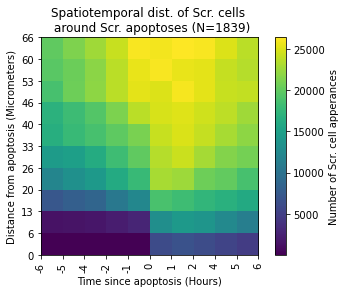

In [20]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 200,
                t_range = 200, 
                title = 'Spatiotemporal dist. of Scr. cells \n around Scr. apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of Scr. cell apperances', 
                save_path ='/home/nathan',# save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/Spatiotemporal dist. of Scr. apoptoses 
 around Scr. apoptoses (N=1839).pdf


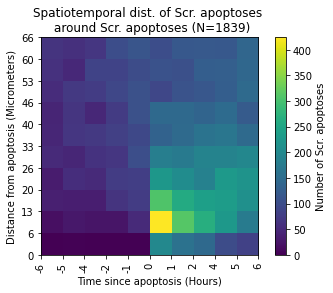

In [19]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 200,
                t_range = 200, 
                title = 'Spatiotemporal dist. of Scr. apoptoses \n around Scr. apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of Scr. apoptoses', 
                save_path = '/home/nathan',#save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True)

Plot saved at  /home/nathan/Spatiotemporal dist. of probability of Scr. apoptoses 
 around Scr. apoptoses (N=1839).pdf


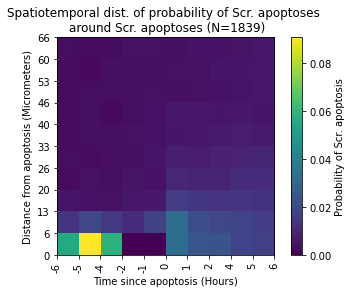

In [21]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 200,
                t_range = 200, 
                title = 'Spatiotemporal dist. of probability of Scr. apoptoses \n around Scr. apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Probability of Scr. apoptosis', 
                save_path = '/home/nathan',#save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True)

# 5) Miscellaneous section: segregating cumulative plots based on experiment type

50:50 expt

In [ ]:
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types'
Path(save_path).mkdir(parents=True, exist_ok=True)

In [ ]:
expt_list_5050 = ['GV0794/Pos4',
                 'GV0794/Pos7',
                 'GV0794/Pos16',
                 'GV0795/Pos4',
                 'GV0795/Pos7',
                 'GV0795/Pos17',
                 'GV0796/Pos4',
                 'GV0796/Pos7',
                 'GV0796/Pos21',
                 'GV0796/Pos22',
                 'GV0797/Pos4',
                 'GV0797/Pos7',
                 'GV0797/Pos20',
                 'GV0797/Pos21',
                 'GV0798/Pos4',
                 'GV0798/Pos7',
                 'GV0798/Pos20',
                 'GV0798/Pos21',
                 'GV0800/Pos4', 
                 'GV0800/Pos7',
                 'GV0800/Pos16',
                 'GV0801/Pos4',
                 'GV0802/Pos4',
                 'GV0804/Pos4',
                 'GV0805/Pos4',
                 'GV0806/Pos4',
                 'GV0807/Pos4',
                 'GV0812/Pos0',
                 'GV0812/Pos1',
                 'GV0812/Pos2',
                 'GV0812/Pos3',
                 'GV0812/Pos4',
                 'GV0812/Pos5',
                 'GV0813/Pos0',
                 'GV0813/Pos1',
                 'GV0813/Pos2',
                 'GV0813/Pos3',
                 'GV0813/Pos4',
                 'GV0813/Pos5',
                 'GV0814/Pos0',
                 'GV0814/Pos11',
                 'GV0814/Pos12',
                 'GV0814/Pos23',
                 'GV0815/Pos0',
                 'GV0815/Pos11',
                 'GV0815/Pos12',
                 'GV0815/Pos23',
                 'GV0816/Pos0',
                 'GV0816/Pos13',
                 'GV0816/Pos14',
                 'GV0816/Pos23',
                 'GV0817/Pos0',
                 'GV0817/Pos11',
                 'GV0817/Pos12',
                 'GV0817/Pos23',
                 'GV0818/Pos12',
                 'GV0818/Pos13',
                 'GV0819/Pos0',
                 'GV0819/Pos1',
                 'GV0819/Pos2',
                 'GV0819/Pos3',
                 'GV0819/Pos4',
                 'GV0819/Pos5',
                 'GV0820/Pos0',
                 'GV0820/Pos1',
                 'GV0820/Pos2',
                 'GV0820/Pos3',
                 'GV0820/Pos4',
                 'GV0820/Pos5']

In [ ]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_5050:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

In [ ]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

In [ ]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

In [ ]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400,  
                title = 'Spatiotemporal dist. of probability of Scribble division \n around wild-type apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

90:10 wt:scr

In [ ]:
expt_list_9010 = ['GV0794/Pos3',
 'GV0794/Pos8',
 'GV0794/Pos15',
 'GV0795/Pos3',
 'GV0795/Pos8',
 'GV0795/Pos16',
 'GV0796/Pos3',
 'GV0796/Pos8',
 'GV0796/Pos19',
 'GV0796/Pos20',
 'GV0797/Pos3',
 'GV0797/Pos8',
 'GV0797/Pos18',
 'GV0797/Pos19',
 'GV0798/Pos3',
 'GV0798/Pos8',
 'GV0798/Pos18',
 'GV0798/Pos19',
 'GV0800/Pos3',
 'GV0800/Pos8',
 'GV0800/Pos15',
 'GV0801/Pos3',
 'GV0802/Pos3',
 'GV0804/Pos3',
 'GV0805/Pos3',
 'GV0806/Pos3',
 'GV0807/Pos3']

In [ ]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_9010:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

In [ ]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

In [ ]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

In [ ]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

10:90 wt:scr

In [ ]:
expt_list_1090 = ['GV0794/Pos5',
 'GV0794/Pos6',
 'GV0795/Pos5',
 'GV0795/Pos6',
 'GV0795/Pos18',
 'GV0796/Pos5',
 'GV0796/Pos6',
 'GV0796/Pos23',
 'GV0796/Pos24',
 'GV0797/Pos5',
 'GV0797/Pos6',
 'GV0797/Pos22',
 'GV0797/Pos23',
 'GV0798/Pos5',
 'GV0798/Pos6',
 'GV0798/Pos22',
 'GV0798/Pos23',
 'GV0800/Pos5',
 'GV0800/Pos6',
 'GV0800/Pos17',
 'GV0801/Pos5',
 'GV0802/Pos5',
 'GV0804/Pos5',
 'GV0805/Pos5',
 'GV0806/Pos5',
 'GV0807/Pos5']

In [ ]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_1090:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

In [ ]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

In [ ]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400,  
                title = 'Spatiotemporal dist. of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

In [ ]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Write a function to do a time evolving plot that iteratively adds single cell heat maps according to the apoptosis time?